Small Notebook for transfer-training a CNN to detect tuberculosis bacteria, marked with the Ziehl-Neelsen method. Training and test data sets are publicly available

The below listed code does not claim to be optimal, neither in terms of structure nor efficiecty. This was just a side project.

## General setup
Load libraries, mount directories etc...

In [ ]:
import os
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.test import gpu_device_name
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import cv2

# install segmentation-models, as colab gives clean instance at the start of each session
!pip install segmentation-models


# Connect to google drive:
drive.mount('/content/drive')
# CHANGE TO OWN SOURCE FOLDER
os.chdir("/content/drive/MyDrive/ABGABE_ML/ML_Mech-20210923T135901Z-001/ML_Mech/src")
# Own files:
from build_model_andi import build_model_andi
from build_model_u import build_model_u


     |████████████████████████████████| 50 kB 5.5 MB/s 
Mounted at /content/drive


In [ ]:
# Check if colab GPU support is active
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Helpers and preprocessing

Here, setup routines for the actual training process can be found. This includes hyperparameters, different models, image preprocessing options etc...

In [ ]:
# Settings
#==============
# General
BATCH_SIZE = 16   # Default is 48, used for training data augmentation

SEED = 420    #Seed for ImageDataGenerator, makes sure x and y are augmented consistently

#Model building
activation='selu'           # Currently selected at model.compile, further down
padding='same'              # "

# Settings for image data augmentation.
ImDatGen_SETTINGS= dict(width_shift_range = 0.1,
                        height_shift_range = 0.1,
                        rotation_range = 30,
                        zoom_range = 0.2)

### Load images

Load cropped images from the data directory.

In [ ]:
def load_train_data():
    ''' Load training data. Non dynamic data structure. Directories should be organized as:
    .
    │
    ├───data
    │   ├───crop
    │   │   ├───testing
    │   │   │
    │   │   └───training
    │   │       └───segmentation
    │   └───raw
    └───src
    Args:
        None

    Returns:
        X   (numpy array): List of image data in RGB
        y   (numpy array): list of groundtruth (gt) bitmasks, grey scale
    '''
    print(os.getcwd())
    # generate path to data
    training_path_x = os.path.join('..', 'data', 'crop', 'training')
    training_path_y = os.path.join('..', 'data', 'crop', 'training', 'segmentation')

    X = []
    y = []
    # find amount of files to be loaded
    num_files = len(os.listdir(str(training_path_y)))
    curr = 0;
    # Iterate over gt, as it contains no dir itself
    for filename in os.listdir(str(training_path_y)):

      #Read img data as Uint8, as histogramm normalisation needs this data type
      img = cv2.imread(os.path.join(training_path_x, filename))
      gt = cv2.cvtColor(cv2.imread(os.path.join(training_path_y, filename)),cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
      X.append(img)
      # Clip label images to rgb
      y.append(gt[:,:,0])
      curr += 1

      print('{} of {}'.format(curr, num_files), end='\r')
      #end='\x1b[1K\r'    <--- just ignore this
    # Transform generated lists to a numpy array with all its gloriouse methods
    X = np.array(X)
    y = np.array(y)

    print('Shape of input: ', X.shape)
    print('Shape of gt: ', y.shape)
    return X, y


### Image preprocessing
Different preprocessing methods for CNN input.

-        img_preproc(): Tranfsorms input to YCrCb2RGB color space and normalises chanels to [0, 1]
-        img_preproc2(): Normalises chanels to [0, 1]
-        img_preproc3(): Transform to L*A*B and perform CLAHE histogram equalisation to L channel
-        img_preproc4(): Zero mean, standart variance
-        img_preproc5(): Saturation and contrastenhancement (results in spread of points in H and S channel)



In [ ]:
def img_preproc(X):
    ''' Perform online data augmentation to x and y images.

    Args:
        X   (list): List of image data in RGB
        y   (list): list of gt bitmasks, grey scale
        batchsize (int): self explanatory
        ImDatGen_SETTINGS (dict): Dict containing ImageDateGenerator Arguments, handed as **kwargs
    Returns:
        X (list): List of processed images

    '''
    dump = np.zeros(np.shape(X))
    # Histogram normalisation:
    i = 0
    for row in X:
      #Transform color space
      ycrcb_img = cv2.cvtColor(row, cv2.COLOR_BGR2YCrCb)
      # histogram normalisation for y channel

      ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
      # convert back to RGB color-space from YCrCb

      cvt_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)
      dump[i,:,:,:] = cvt_img
      i += 1
    print('preprocessing done')
    dump = dump.astype(np.float32)/255.0
    print(np.amax(dump[0]))
    return dump

In [ ]:
def img_preproc2(X):
  # Convert to float
  X = X.astype(np.float32)
  X *= 1/X.max()

  #print(X.min(), X.max())
  return X

In [ ]:
def img_preproc3(X):
  dump = np.zeros(X.shape)
  print(dump.shape)
  # Convert BGR2LAB and perform contrast enhancement

  print(X.max())
  print(X.min())

  i = 0
  for row in X:
    if i ==0:
      print(row.shape)
      print(row.max())
    lab= cv2.cvtColor(row, cv2.COLOR_BGR2LAB)
    if i ==0:
      print(row.shape)
      print(row.max())

    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel---------------------------------
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl,a,b))
    dump[i] = limg
    dump[i] = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    i += 1
  dump *= 1/dump.max()
  plt.imshow(dump[0])
  return dump


In [ ]:
from PIL import Image, ImageEnhance

def img_preproc5(X):
  """ Enhance image Saturation and Contrast
  """
  dump = np.zeros(X.shape)
  i = 0
  for row in X:
    img = Image.fromarray(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
    converter = ImageEnhance.Color(img)
    # Select saturation factor
    color_img = converter.enhance(5)
    contr = ImageEnhance.Contrast(color_img)
    # Select contrast factor
    enh_img = contr.enhance(1.5)
    dump[i] = np.array(enh_img)
    i += 1
  print(dump[0].shape)
  dump = dump.astype(np.float32)
  dump *= 1/dump.max()
  plt.imshow(dump[0])
  return dump


In [ ]:
def img_preproc4(X):
  # Convert to float
  X = X.astype(np.float32)
  X *= 1/X.max()
  #x_norm = np.zeros(X.shape)

  # Zero mean
  X[:,:,:,0] -= np.mean(X[:,:,:,0])
  X[:,:,:,1] -= np.mean(X[:,:,:,1])
  X[:,:,:,2] -= np.mean(X[:,:,:,2])
  # Std Variance
  X[:,:,:,0] /= np.sqrt(np.var(X[:,:,:,0]))
  X[:,:,:,1] /= np.sqrt(np.var(X[:,:,:,1]))
  X[:,:,:,2] /= np.sqrt(np.var(X[:,:,:,2]))

  # Scale back to intervall [0,1]
  print(X.min(), X.max())
  return X

In [ ]:
def data_generator(x, y, ImDatGen_SETTINGS, batchsize=48, seed=42):
    ''' Perform online data augmentation to x and y images.

    Args:
        X   (list): List of image data in RGB
        y   (list): list of gt bitmasks, grey scale
        batchsize (int): self explanatory
        ImDatGen_SETTINGS (dict): Dict containing ImageDateGenerator Arguments, handed as **kwargs
    Returns:
        training_iterator (tuple): Iterator for training process,

    '''

    x_gen = ImageDataGenerator(**ImDatGen_SETTINGS)
    y_gen = ImageDataGenerator(**ImDatGen_SETTINGS)

    x_gen.fit(x)
    y_gen.fit(y)

    # TODO check if second argument of flow method (labels) can be used like this
    #print(x.shape)
    #x_iterator = x_gen.flow(x, x, batch_size=batchsize, seed=seed)
    #y_iterator = y_gen.flow(y, y, batch_size=batchsize, seed=seed)

    x_iterator = x_gen.flow(x, batch_size=batchsize, seed=seed)
    y_iterator = y_gen.flow(y, batch_size=batchsize, seed=seed)

    #print(next(zip(x_iterator, y_iterator)))

    return  zip(x_iterator, y_iterator)


## Models
Several different U-Net architectures.
Randomly initialized as well as already pretrained nets.

*CAREFULL,

### Model U-Net
A simple handmade U-Net

Model definition:

In [ ]:
# 11.08.2021
# U-Net Model based on https://arxiv.org/pdf/1505.04597.pdf
# impmenetation from source: https://github.com/bnsreenu/python_for_microscopists/blob/master/204-207simple_unet_model.py

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()

    return model


Build and compile model:

In [ ]:
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
clear_session()
# Build model
model = simple_unet_model(128,128,3)

# and compile it

# Set learning rate for the model (does not work with LR much higher than 0.001)
opt = Adam(learning_rate = 0.0001)
model.compile(opt, loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])
#plot_model(model, show_shapes=True, show_dtype=False, show_layer_names=True, expand_nested=False)
#model.summary()

Segmentation Models: using `keras` framework.


In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model_u_1509_1.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

### Transfer learning

generate and compile pretrained resnet34 with imagenet weights. Works pretty smoothly, thanks to segmentation_models lib.


In [ ]:
import segmentation_models as sm
# Segmentation Models: using `keras` framework.
# https://github.com/qubvel/segmentation_models
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam


clear_session()

sm.set_framework('tf.keras')

sm.framework()

model = Unet(backbone_name="resnet34", encoder_weights="imagenet",input_shape=(128,128,3))#,encoder_freeze=True)

# Set learning rate for the model (does not work with LR much higher than 0.001)
opt = Adam(learning_rate = 0.0001)
model.compile(opt, loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])
model.summary()

Visualize model:

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model, to_file='model_sm_1509_1.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None)

###Lecture model
Slightly different U-Net as provided above. Taken from the ML-Mech lecture

Model definition

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, add
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm

clear_session()

def get_model(img_size, num_classes, kernel_size, filter_sizes, strides, activation, batch_norm, dropout):
    # the input layer determines the image size input into the network
    inputs = Input(shape=img_size + (3,))   # 3 means RGB

    ### downsampling

    # entry block
    x = Conv2D(filter_sizes[0], kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    if batch_norm: x = BatchNormalization()(x)
    x = Activation(activation)(x)

    previous_block_activation = x  # Set aside residual

    # next blocks are identical apart from the feature depth
    for filters in filter_sizes[1:]:

        x = Activation(activation)(x)
        x = SeparableConv2D(filters, kernel_size=kernel_size, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = Activation(activation)(x)
        x = SeparableConv2D(filters, kernel_size=kernel_size, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)
        if dropout: x = Dropout(0.02)(x)
        x = MaxPooling2D(3, strides=strides, padding="same")(x) # pool_size=3

        # Project residual
        residual = Conv2D(filters, 1, strides=strides, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])         # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### upscaling

    for filters in filter_sizes[::-1]:
        x = Activation(activation)(x)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = Activation(activation)(x)
        x = Conv2DTranspose(filters, kernel_size=kernel_size, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # per-pixel classification layer
    outputs = Conv2D(num_classes, kernel_size=kernel_size, activation="sigmoid", padding="same")(x) # softmax

    # create the model
    model = Model(inputs, outputs)

    return model


Model compilation

In [ ]:
clear_session()
# Build model
model = get_model((128,128),
                  1,
                  3,
                  [32, 64, 128, 256],
                  2,
                  "selu",
                  True,
                  False)

# and compile it

# Set learning rate for the model (does not work with LR much higher than 0.001)
opt = Adam(learning_rate = 0.0001) # proved to be a good value
model.compile(opt, loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])


Vidualize model

In [ ]:
plot_model(model, show_shapes=True, show_dtype=False, show_layer_names=True, expand_nested=False)
model.summary()

### HPO: SK-Learn

using the above defined Unet, slightly adapted (adapted)

**(not fully implemented in current version)**

Model definition:

In [ ]:

# U-Net Model based on https://arxiv.org/pdf/1505.04597.pdf
# impmenetation from source: https://github.com/bnsreenu/python_for_microscopists/blob/master/204-207simple_unet_model.py

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def simple_unet_model_hpo(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3,log_learning_rate=-3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #learning_rate=0.0001
    optimizer = Adam(learning_rate=10**log_learning_rate)
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    model.compile(optimizer,loss=sm.losses.binary_focal_dice_loss, metrics="jaccard")

    return model

Define parameter space to explore and build model

In [ ]:
#Hyperparameter Optimization
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


#Build model
clear_session()


#change the input vectors
#x_train_hpo = x_train.reshape(103,49152)
#y_train_hpo = y_train.reshape(103,16384)

#set parameter
##learning_rate=0.0001
##opt = Adam(lr=learning_rate)
param_space = {"log_learning_rate": [-4,-3, -2, -1],
               "batch_size": [8,16,32,64],
               "epochs": [50,100,150,200]}

# implement the scikit learn classifier interface
#requires model defined as a function (done above)
ann_clf = KerasClassifier(build_fn=simple_unet_model_hpo)





### HPO: TF Board

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/
from tensorboard.plugins.hparams import api as hp
from tensorflow.summary import create_file_writer, scalar
import datetime

Helper functions for later training

In [ ]:
def train_test_model(hparams):

  # generate unet model from above with handed hp
  model = simple_unet_model(128,128,3)

  optimizer = Adam(learning_rate=10**hparams[HP_LR])

  model.compile(optimizer,loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

  model.fit(train_iterator, batch_size=hparams[HP_BS], steps_per_epoch=32, epochs=1, verbose=1, validation_data=val_iterator, validation_batch_size=16, validation_steps=10)
  _,jaccard = model.evaluate(train_iterator)
  return jaccard

def run(run_dir, hparams):
  with create_file_writer(run_dir).as_default():
    hp.hparams(hparams) # record the values used in this trial
    jaccard = train_test_model(hparams)
    scalar(METRIC, jaccard, step=1)

Define hyperparameter space for HPO-exploration:
The HPO is based on the above simple_unet_model. Model compilation for the different hp as well as training is done below in section "training".

In [ ]:
HP_LR = hp.HParam("log_learning_rate",hp.Discrete([-4,-3, -2, -1]))
HP_BS = hp.HParam("batch_size",hp.Discrete([8,16,32,64]))
#HP_EP = hp.HParam("epochs",hp.Discrete([50,100,150,200]))
METRIC = 'iou_score'

#log HP config
with create_file_writer('logs/hparam_tuning').as_default(): hp.hparams_config(hparams=[HP_LR,HP_BS],metrics=[hp.Metric(METRIC,display_name='iou_score')],)

##Custom Callbacks

Callback function for training (produces the nice output plot)

Thanks Andi

In [ ]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class CustomCallback(Callback):
    def __init__(self, epochs):
        self.epochs = epochs

    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []

        self.samples = 4

        self.img, self.mask = next(train_iterator)

        #self.img, self.mask = np.zeros((self.samples, *img.shape[1:])), np.zeros((self.samples, *mask.shape[1:]))
        #for i in range(self.samples):
        #    img, mask = next(train_iterator)
        #    self.img[i], self.mask[i] = img.reshape(-1,*img.shape), mask.reshape(-1,*mask.shape)

        #while self.img.shape[0] < self.samples:
        #    self.img, self.mask = next(test_iterator)

        #self.samples = min(self.img.shape[0], 6)
        #print(self.samples)


    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs["loss"])
        #self.val_losses.append(logs["val_loss"])
        self.metric.append(logs["iou_score"])
        #self.val_metric.append(logs["val_iou_score"])

        epoch_pred = model.predict(self.img)#.reshape(self.img.shape[0],128,128,3))

        clear_output(wait=True)

        fig = plt.figure(figsize=(16,16))
        axs = []
        axs.append(fig.add_subplot(2+self.samples,2,1))
        axs.append(fig.add_subplot(2+self.samples,2,2))
        for i in range(self.samples): #self.samples):
            for j in range(6):
                #print(i,j,(2+self.samples)*i+j+2+self.samples+1)
                axs.append(fig.add_subplot(2+self.samples,6,(2+self.samples)*i+j+2+self.samples+1))

        fig.suptitle(f"Epoch {epoch+1}", fontsize=24)

        axs[0].plot(self.x, self.losses, lw=4, label="loss")
        #axs[0].plot(self.x, self.val_losses, lw=4, label="val_loss")
        axs[0].legend(fontsize=16)
        axs[0].set_xlabel("Epoch", fontsize=16)
        axs[0].set_ylabel("Loss", fontsize=16)
        axs[0].set_yscale("log")

        axs[1].plot(self.x, self.metric, lw=4, label="iou_score")
        #axs[1].plot(self.x, self.val_metric, lw=4, label="val_iou_score")
        axs[1].legend(fontsize=16)
        axs[1].set_xlabel("Epoch", fontsize=16)
        axs[1].set_ylabel("Metric", fontsize=16)
        #axs[1].set_yscale("log")

        [axs[k].set_xlim([0,self.epochs-1]) for k in range(2)]


        # uncomment following when noisy data is used
        titles = ["Image", "Prediction", "Ground Truth", "Pred Overlay", "GT Overlay", "Difference"]

        y_pred_thresh = epoch_pred.copy()
        y_pred_thresh = np.interp(y_pred_thresh, (y_pred_thresh.min(), y_pred_thresh.max()), (0, +1))
        #y_pred_thresh[y_pred_thresh<thresh] = np.nan

        #axs[1].hist(y_pred_thresh.flatten(), bins=20, density=True)

        x_test_ranged = self.img.copy()
        x_test_ranged = np.interp(x_test_ranged, (x_test_ranged.min(), x_test_ranged.max()), (0, +1)) #(x_test_ranged+1)/2

        y_test_ranged = self.mask.copy()
        y_test_ranged = np.interp(y_test_ranged, (y_test_ranged.min(), y_test_ranged.max()), (0, +1)) #(y_test_ranged+1)/2
        #y_test_ranged[y_test_ranged<0.6] = np.nan

        #fig,axs = plt.subplots(samples,6, figsize=(16,3*samples))

        diff_vals = y_test_ranged[:,:,:,0]-y_pred_thresh[:,:,:,0] #((y_test_ranged-y_pred_thresh)+1)/2
        diff_vals = np.interp(diff_vals, (diff_vals.min(), diff_vals.max()), (0, +1))

        for i in range(self.samples):
            #print(x_test_ranged.shape)
            #print(y_pred_thresh.shape)
            axs[2+6*i+0].imshow(x_test_ranged[i])
            #axs[2+6*i+1].imshow(y_pred_thresh[i])
            axs[2+6*i+1].imshow(np.reshape(y_pred_thresh[i],(128,128)))
            axs[2+6*i+2].imshow(y_test_ranged[i,:,:,0])
            axs[2+6*i+3].imshow(x_test_ranged[i])
            #axs[2+6*i+3].imshow(y_pred_thresh[i], alpha=0.5)
            axs[2+6*i+3].imshow(np.reshape(y_pred_thresh[i],(128,128)), alpha=0.5)
            axs[2+6*i+4].imshow(x_test_ranged[i])
            axs[2+6*i+4].imshow(y_test_ranged[i,:,:,0], alpha=0.5)
            axs[2+6*i+5].imshow(diff_vals[i], cmap='Spectral')
            for j in range(6):
                axs[2+6*i+j].axis("off")

        for i in range(6):
            axs[2+i].set_title(titles[i], fontsize=15)
        #axs[0,1].set_title("Prediction", fontsize=26)
        #axs[0,2].set_title("Ground Truth", fontsize=26)
        #axs[0,3].set_title("Overlay", fontsize=26)
        plt.tight_layout()
        loc = os.path.join('..','report')
        plt.savefig(f"{loc}/training_anim_{epoch}.png")
        plt.show()

        # place your conditional statement here
        # it should check whether the current loss is below 3.3*10^-3 and then
        # set self.model.stop_training to True
        # you can additionally provide a print() statement
        ### BEGIN SOLUTION
        #if logs["loss"][-1] < 3.3e-3:
        #    print(f"Loss < 3.3e-3, stopping training early at epoch {epoch}")
        #    self.model.stop_training = True
        ### END SOLUTION

custom_callback = CustomCallback(20)

# Data Setup
The below listed code is ment to be run with every training session. It controlls the general data flow, such as loading the original image data, cerating test sets as well as applying preprosessing.

Load data and plot verification

/content/drive/My Drive/ML_Mech/src
Shape of input:  (122, 128, 128, 3)
Shape of gt:  (122, 128, 128)
Shape of train data:  (103, 128, 128, 3) (103, 128, 128, 1)
Shape of vali. data:  (19, 128, 128, 3) (19, 128, 128, 1)


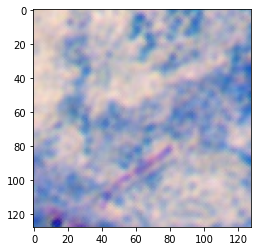

In [ ]:
# Load Data
x, y = load_train_data()
# Add additional axis to label data. (So x and y have the same structure)
y = y[:,:,:,np.newaxis];
# Split data to training and validation data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)
# Show loaded image to make shure stuff loaded correctly
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_BGR2RGB))
print('Shape of train data: ', x_train.shape, y_train.shape)
print('Shape of vali. data: ', x_val.shape, y_val.shape)

###OPTIONAL VISUALISATIONS

The following cell is just to visualize the result of the preprocessing before shuffle. Could produce issues, depending on the preprosseing used

(128, 128, 3)
1.0


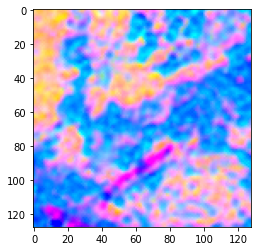

In [ ]:
blubb = img_preproc5(x_train)
print(blubb.max())
plt.imshow(blubb[0])

Cell to try out the results of different PIL preprocessing stuff. (not mendatory)

(128, 128, 3)


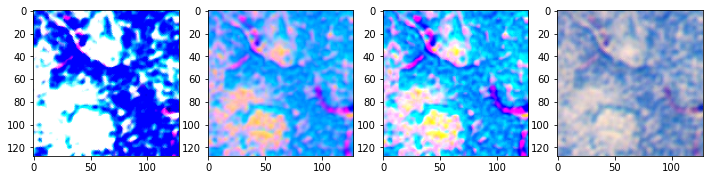

In [ ]:

test_f_path = os.path.join('..', 'data','crop', 'training', 'cropimg3.jpg__4_6.png')
img = Image.open(test_f_path)
img = cv2.imread(test_f_path)
img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
converter = ImageEnhance.Color(img)
contr = ImageEnhance.Contrast(img)
img2 = contr.enhance(8)
fig, axs = plt.subplots(1,4, figsize=(12,6))
axs[0].imshow(img2)
print(np.array(img2).shape)
img2 = converter.enhance(5)
contr = ImageEnhance.Contrast(img2)
img3 = contr.enhance(2)
axs[1].imshow(img2)

axs[2].imshow(img3)
axs[3].imshow(img)

## CONTINUE IMPORTANT STUFF

Here the important stuff continues:
For different preprosessing steps, the function call needs to be adapted by hand

e.g. img_preproc4() --> img_preproc5()

(128, 128, 3)
(128, 128, 3)
(103, 128, 128, 3)


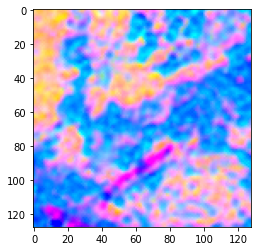

In [ ]:

# preprocessing of X data for Training and validation
x_train = img_preproc5(x_train)
x_val = img_preproc5(x_val)
plt.imshow(x_train[0])
print(x_train.shape)

In [ ]:
# Plot min and max values of training data to check if normalisation worked
print(np.amin(x_train))
print(np.amax(x_train))
print(np.amin(y_train))
print(np.amax(y_train))

0.0
1.0
0.0
1.0


float32
Range of img: 0.0 - 1.0
Range of mask: 0.0 - 1.0
(16, 128, 128, 3) (16, 128, 128, 1)


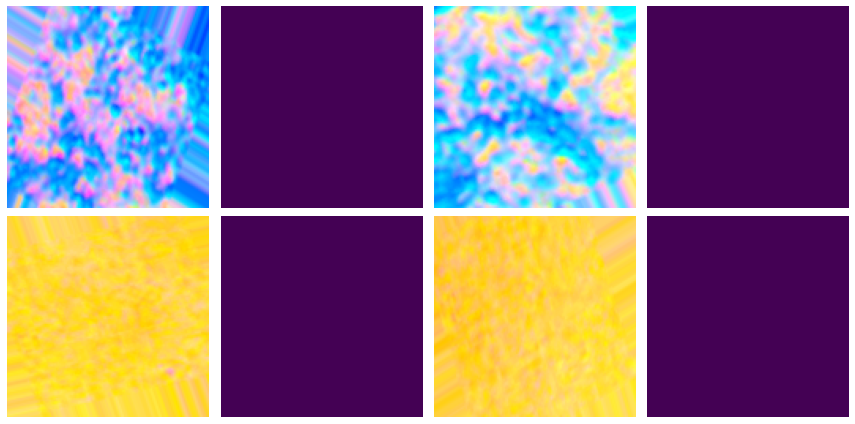

In [ ]:
# Plot some masks and images for overview,

#--------------------

fig,axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.flatten()
# Create iterator instances
train_iterator = data_generator(x_train, y_train, ImDatGen_SETTINGS, batchsize=BATCH_SIZE, seed=SEED)
val_iterator = data_generator(x_val, y_val, ImDatGen_SETTINGS, batchsize=BATCH_SIZE, seed=SEED)

# Plot from one iteration
img, mask = next(train_iterator)
print(img[0].dtype)
print('Range of img: {} - {}'.format(np.amin(img),np.amax(img)))
print('Range of mask: {} - {}'.format(np.amin(mask),np.amax(mask)))
#Plot in same logic as in assignment
for i in range(4):
    #ggf display issues, due to HSV color space
    axs[2*i].imshow(img[i])
    axs[2*i+1].imshow(np.reshape(mask[i],(128,128)))

for ax in axs:
    ax.axis("off")
plt.tight_layout()

print(img.shape, mask.shape)

#Training

## Standart Training

### Train

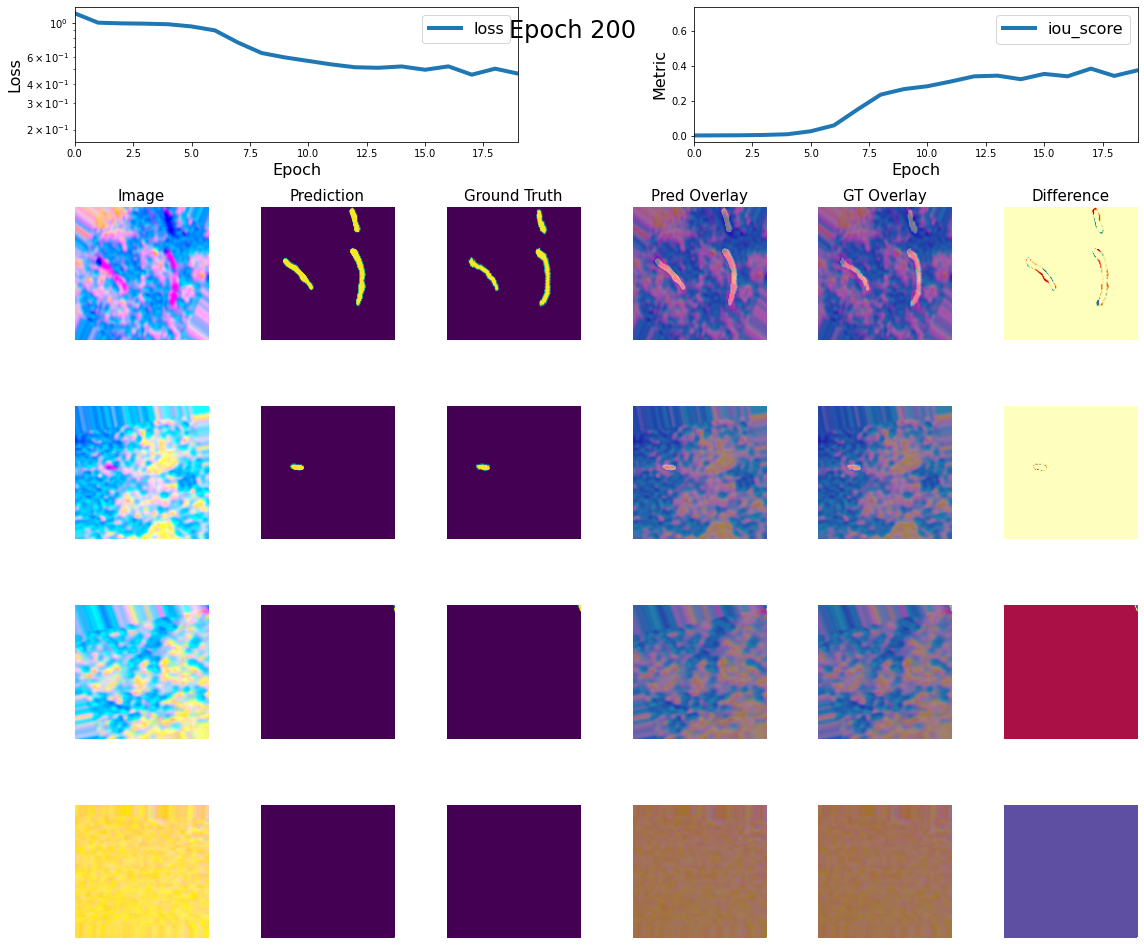

Last loss:  0.19054700434207916
Last IOU:  0.6913443803787231
Last val_loss:  0.49091023206710815
Last val_IOU:  0.30836254358291626


In [ ]:
import tensorflow as tf
import segmentation_models as sm
# TODO: Think about other losses and metrics

# Force usage of GPU: (code from colab documentation)
#device_name = gpu_device_name()
#if tf.gpu_device_name() != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

#opt = Adam(learning_rate = 0.0001)
#model.compile(opt, loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

with tf.device('/device:GPU:0'):
  history = model.fit(train_iterator, batch_size=48, steps_per_epoch=32, epochs=200, verbose=1, validation_data=val_iterator, validation_batch_size=16, validation_steps=10,  callbacks=custom_callback)

print('Last loss: ', history.history['loss'][-1])
print('Last IOU: ', history.history['iou_score'][-1])
print('Last val_loss: ', history.history['val_loss'][-1])
print('Last val_IOU: ', history.history['val_iou_score'][-1])


### Visualisation and Prediction for Testimages

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])


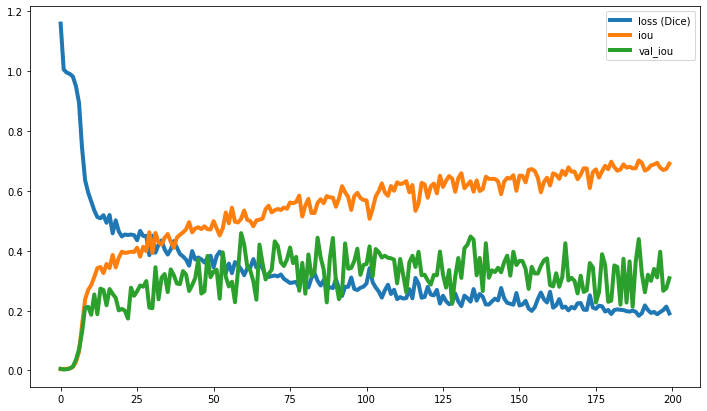

In [ ]:
# Plot training history:
plt.figure(figsize=(12,7))

plt.plot(history.history["loss"], lw=4, label="loss (Dice)")
print(history.history.keys())
plt.plot(history.history["iou_score"], lw=4, label="iou")
plt.plot(history.history["val_iou_score"], lw=4, label="val_iou")
plt.legend()

999.9994039535522

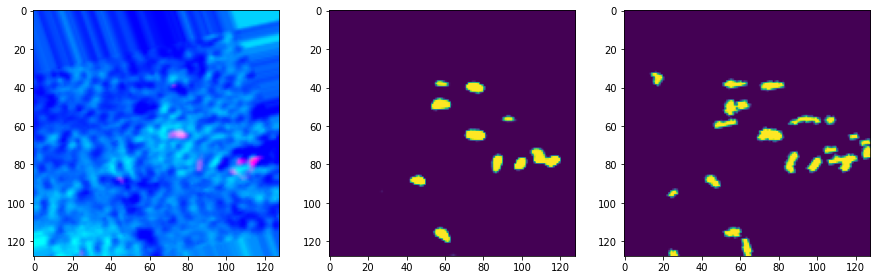

In [ ]:
# Predict mask for image in training set. Order: preprocessed training image, prediction, groundtruth
# Selects the image
ix = 15

y_hat_mask = model.predict(np.reshape(img[ix],(1,128,128,3)))
fig,axs = plt.subplots(1,3, figsize=(15,7))

axs[0].imshow(img[ix])
axs[1].imshow(y_hat_mask.reshape(128,128))
axs[2].imshow(mask[ix].reshape(128,128))

y_hat_mask.max()*1000

(128, 128, 3)
(1, 128, 128, 3)


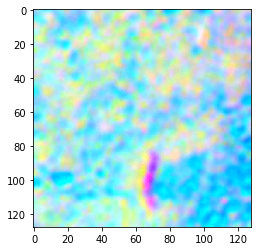

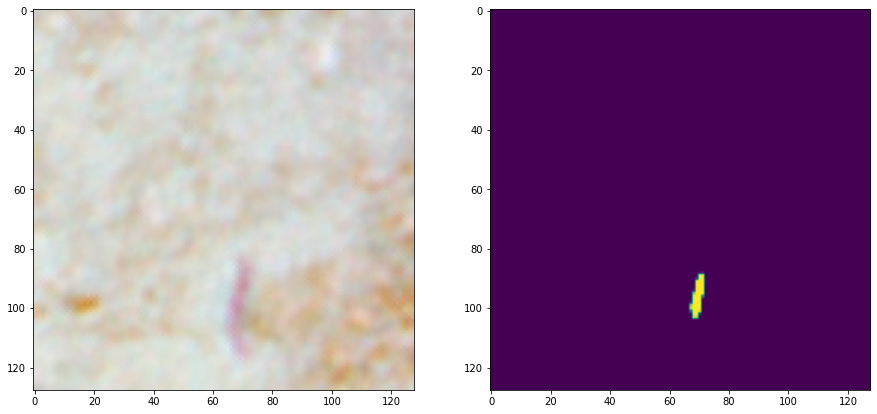

In [ ]:

# Predict image from test set
test_f_path = os.path.join('..', 'data', 'data_old','crop', 'testing', 'atest.png')
#82af34fe-354e-4345-a804-e99ba98c49a4_0x4-4-130,600193805524.jpg__4_2.png
test_img = cv2.imread(test_f_path)
#print(test_img.shape)
test_img = np.reshape(test_img,(1,128,128,3))
pred_input = img_preproc5(test_img)
print(test_img.shape)

y_hat_mask = model.predict(np.reshape(pred_input,(1,128,128,3)))

fig,axs = plt.subplots(1,2, figsize=(15,7))

axs[0].imshow(np.reshape(test_img,(128,128,3)))
axs[1].imshow(y_hat_mask.reshape(128,128))

# Image order: preprocessed test image, original test image, predicted mask

In [ ]:
# Save model if you want to
path_to_save = os.path.join('..','reports','Unet_1609_2')
model.save(path_to_save)

## HPO Training

### SK-LEARN
(not supported in this version)

In [ ]:

# instantiate a GridSeachCV object that can be used like a
# sciki-learn classifier
grid_search = GridSearchCV(estimator=ann_clf, param_grid=param_space, cv=5, scoring="jaccard", return_train_score = True, verbose=True, n_jobs=1)

# "fit" classifiers to the data
grid_result = grid_search.fit((x_train,y_train), epochs=3, verbose=1, validation_data=(x_val, y_val))

### Tensorflow

In [ ]:
session_num = 0
for LR in HP_LR.domain.values:
  for BS in HP_BS.domain.values:
    #for EP in HP_EP.domain.values:
      hparams = {
      HP_LR: LR,
      HP_BS: BS,
      #HP_EP: EP,
      }
      run_name = f"run-{session_num}"
      print(f'--- Starting trial: {run_name}')
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1